In [1]:
import numpy as np
import os
import librosa as lb
import soundfile as sf
import museval
from matplotlib import pyplot as plt
from tqdm import tqdm
import librosa.display

In [346]:
def updateA(X, S):
    
    n, l = X.shape
    I = np.eye(n)
    regularizer = 0.00001
    
    XST = X @ S.T
    SST = S @ S.T
    F1 = (XST + regularizer*I)
    F2 = (SST + regularizer*I)
    F2_inv = np.linalg.inv(F2)
    A = F1 @ F2_inv
    return A

In [347]:
def updateS(X, A, m, O):
    n, l = X.shape
    #O = np.ones((n, 1))
    ATA = A.T @ A
    ATX = A.T @ X
    F1 = (ATA + O @ O.T)
    F1_inv = np.linalg.inv(F1)
    F2 = (O @ m + A.T @ X)
    S = F1_inv @ F2
    return S

In [348]:
def objective(X, A, S, m, O):
    return np.linalg.norm(X-(A@S))**2 + np.linalg.norm(m-(O.T @ S))**2

In [349]:
def project(A, gamma1, gamma2):
    n, _ = A.shape
    for i in range(n):
        for j in range(n):
            if i!=j:
                if A[i][j] > gamma2:
                    A[i][j] = gamma2
                if A[i][j] < gamma1:
                    A[i][j] = gamma1
            else:
                #pass
                #A[i][j] = 1
                
                if A[i][j] > 1.25:
                    A[i][j] = 1
                elif A[i][j] < 0.75:
                    A[i][j] = 1
                
                
    return A

In [350]:
def Minimize(X, m, O, gamma1, gamma2, tol=1e-3, max_iter=1000):
    n, l = X.shape
    A = np.eye(n)
    S_opt = X.copy()
    
    iters = 0
    while True:
        
        A_opt = updateA(X, S_opt)
        A_opt = project(A_opt, gamma1, gamma2)
        S_opt = updateS(X, A_opt, m, O)
        loss = objective(X, A_opt, S_opt, m, O)
        #print('ITERATION:', iters+1, 'LOSS:', loss, sep=' ')
        if iters>0 and (prev_loss - loss) <= tol:
            break
        prev_loss = loss
        iters +=1
        if iters >= max_iter:
            print('MAXIMUM ITERATION REACHED!!!')
            break
        
    return A_opt, S_opt

In [351]:
clean_path = "/home/rajesh/Desktop/"

In [375]:
vocals, fs = lb.load(clean_path+'vocals.wav')
bass, fs = lb.load(clean_path+'bass.wav')
drums, fs = lb.load(clean_path+'drums.wav')
other, fs = lb.load(clean_path+'other.wav')

smix, fs = lb.load(clean_path+'smix.wav')
xmix, fs = lb.load(clean_path+'xmix.wav')

In [376]:
bvocals, fs = lb.load(clean_path+'bvocals.wav')
bbass, fs = lb.load(clean_path+'bbass.wav')
bdrums, fs = lb.load(clean_path+'bdrums.wav')
bother, fs = lb.load(clean_path+'bother.wav')

mixture, fs = lb.load(clean_path+'mixture.wav')

In [377]:
X = np.array([bvocals, bbass, bdrums, bother])
S = np.array([vocals, bass, drums, other])
m = np.array([xmix]) #NOTE HERE

In [378]:
X.shape, S.shape, m.shape

((4, 220500), (4, 220500), (1, 220500))

In [397]:
O = (m @ np.linalg.pinv(S)).T
#O = np.array([np.ones(4)]).T
O.T, O.shape

(array([[0.9409983 , 0.87000006, 1.1549996 , 0.9960002 ]], dtype=float32),
 (4, 1))

In [398]:
block = 25
A_pred, S_pred = [], []

for i in tqdm(range(0, X.shape[1], block)):
    x_ = X[:, i:i+block]
    m_ = m[:, i:i+block]
    A_opt, S_opt = Minimize(x_, m_, O, 0.0001, 1, tol=1e-6)
    S_pred.append(S_opt)
    A_pred.append(A_opt)
    
S_pred = np.hstack(S_pred)

100%|███████████████████████████████████████████████████████████| 8820/8820 [00:10<00:00, 841.29it/s]


In [399]:
outpath = "/home/rajesh/Desktop/"

In [400]:
sf.write(outpath+'vocal_pred.wav', S_pred[0], fs)
sf.write(outpath+'bass_pred.wav', S_pred[1], fs)
sf.write(outpath+'drums_pred.wav', S_pred[2], fs)
sf.write(outpath+'others_pred.wav', S_pred[3], fs)

### SPECTRA

In [401]:
stft_bv = lb.stft(bvocals)
stft_bb = lb.stft(bbass)
stft_bd = lb.stft(bdrums)
stft_bo = lb.stft(bother)

In [402]:
stft_v = lb.stft(vocals)
stft_b = lb.stft(bass)
stft_d = lb.stft(drums)
stft_o = lb.stft(other)

In [403]:
stft_vp = lb.stft(S_pred[0])
stft_bp = lb.stft(S_pred[1])
stft_dp = lb.stft(S_pred[2])
stft_op = lb.stft(S_pred[3])

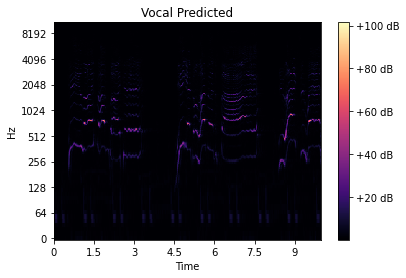

In [404]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_vp), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Vocal Predicted')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(outpath+'VocalpredictedSpect.png')

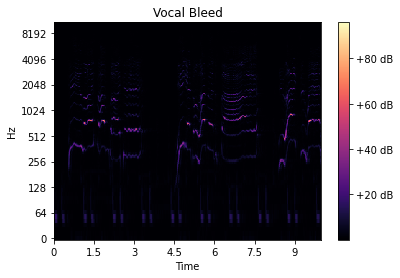

In [405]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_bv), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Vocal Bleed')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(outpath+'VocalBleedSpect.png')

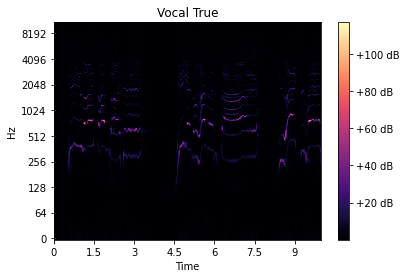

In [406]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_v), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Vocal True')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(outpath+'VocalTrueSpect.png')

### SDR

In [407]:
def get_metrics(y):
    avg_y = []
    for i in range(len(y)):
        x = y[~np.isnan(y)]
        avg = sum(x)/len(x)
        avg_y.append(avg)
    return avg_y

In [408]:
def compute_sdr(true, reconstructed, fs):
    t = np.array([true])
    r = np.array([reconstructed])

    sdr, isr, sir, sar = museval.evaluate(t, r, win=fs, hop=fs)
        
    avg_sdr = get_metrics(sdr)
    avg_isr = get_metrics(isr) #Source to Spatial Distortion Image
    avg_sir = get_metrics(sir)
    avg_sar = get_metrics(sar)

    return sum(avg_sdr)/len(avg_sdr)

In [409]:
v_sdr = compute_sdr(vocals, bvocals, fs)
b_sdr = compute_sdr(bass, bbass, fs)
d_sdr = compute_sdr(drums, bdrums, fs)
o_sdr = compute_sdr(other, bother, fs)

true_sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
true_sdr, v_sdr, b_sdr, d_sdr, o_sdr

(11.62230000951866,
 13.314210152932864,
 8.87863828886928,
 15.935045808207644,
 8.36130578806485)

In [410]:
v_sdr = compute_sdr(vocals, S_pred[0], fs)
b_sdr = compute_sdr(bass, S_pred[1], fs)
d_sdr = compute_sdr(drums, S_pred[2], fs)
o_sdr = compute_sdr(other, S_pred[3], fs)

obtained_sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
obtained_sdr, v_sdr, b_sdr, d_sdr, o_sdr

(12.343207381035354,
 15.769461228530423,
 10.629748059194828,
 14.703679969131795,
 8.269940267284376)

In [411]:
(obtained_sdr - true_sdr) / true_sdr * 100

6.202794377414715

In [412]:
A_avg = np.average(A_pred, axis=0)
np.round(A_avg, 4)

array([[9.6350e-01, 1.0000e-04, 3.4200e-02, 1.0000e-04],
       [1.0000e-04, 9.1410e-01, 3.1500e-02, 3.0000e-04],
       [2.0000e-04, 1.0000e-04, 1.0406e+00, 2.0000e-04],
       [2.0000e-04, 1.0000e-04, 3.6100e-02, 9.9730e-01]])

In [413]:
A_act = X @ np.linalg.pinv(S)
np.linalg.norm(A_act - A_avg)**2

0.288422306936214

In [414]:
np.round(A_act, 4)

array([[0.82 , 0.02 , 0.09 , 0.016],
       [0.021, 0.71 , 0.15 , 0.16 ],
       [0.01 , 0.12 , 0.9  , 0.16 ],
       [0.09 , 0.02 , 0.015, 0.66 ]], dtype=float32)